# Beesline Capstone: Price Optimization

## First: Build Dataset

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings('ignore')

In [ ]:
sys = pd.read_csv('sys_22_23.csv', low_memory=False)
sys.tail()

,Unnamed: 0,id,source,date,InvoiceNo,ItemCode,LotNo,qty_sold,qty_free,qty_returned,total_qty,currency,ptt_price,discount,total_sales_amount,sales_person_id,sales_person_name,customer_id,channel_type,ecom_customername,ecom_customercity,ecom_customeraddress_1,ecom_customeraddress_2,ecom_customeraddress_3,ecom_customerphone,ecom_customeremail,ecom_customerawb,itemprice_id,import_date,y
470806,93671,7274870,Ecommerce,2023-06-07,23PSI19465,5281018020074,30753/31423C,1,0,NaN,1,USD,74.6859,0.00,1262.4145,SP04,E-Commerce,C00153,ONLINE,ROWAIDA CHEHAYEB -49113270964,Beirut,Ain Jdide Mount Lebanon,Address Nickname:Home | Address Type:Apartment,NaN,71517400,Chehayebrowaida@gmail.com,ROWAIDA CHEHAYEB -49113270964,NaN,NaN,2023
470807,93672,7274871,Ecommerce,2023-06-07,23PSI19466,5281018711088,29230/44422F,1,0,NaN,1,USD,613.6505,0.00,1728.9225,SP04,E-Commerce,C00153,ONLINE,LAMA AKKAWI -49113271001,Bourj Al Barajinah,Beirut,Address Nickname:Home | Address Type:Apartment,NaN,76623461,lamaakkawi@gmail.com,LAMA AKKAWI -49113271001,NaN,NaN,2023
470808,93673,7274872,Ecommerce,2023-06-07,23PSI19466,801384,NaN,1,0,NaN,1,USD,0.0000,0.00,1728.9225,SP04,E-Commerce,C00153,ONLINE,LAMA AKKAWI -49113271001,Bourj Al Barajinah,Beirut,Address Nickname:Home | Address Type:Apartment,NaN,76623461,lamaakkawi@gmail.com,LAMA AKKAWI -49113271001,NaN,NaN,2023
470809,93674,7274873,Ecommerce,2023-06-07,23PSI19466,5281018710944,30998/41723D,1,0,NaN,1,USD,724.5646,0.00,1728.9225,SP04,E-Commerce,C00153,ONLINE,LAMA AKKAWI -49113271001,Bourj Al Barajinah,Beirut,Address Nickname:Home | Address Type:Apartment,NaN,76623461,lamaakkawi@gmail.com,LAMA AKKAWI -49113271001,NaN,NaN,2023
470810,93675,7274874,Ecommerce,2023-06-07,23PSI19466,5281018710951,29604/14822I,1,0,NaN,1,USD,390.7075,86.73,1728.9225,SP04,E-Commerce,C00153,ONLINE,LAMA AKKAWI -49113271001,Bourj Al Barajinah,Beirut,Address Nickname:Home | Address Type:Apartment,NaN,76623461,lamaakkawi@gmail.com,LAMA AKKAWI -49113271001,NaN,NaN,2023


In [ ]:
web_21 = pd.read_csv(r"C:\Users\USER\Downloads\Data\Data\Website 2021-2023\2021\2021 Website Data.csv", low_memory=False)
web_22 = pd.read_csv(r"C:\Users\USER\Downloads\Data\Data\Website 2021-2023\2022\2022 Website Data.csv", low_memory=False)
web_23 = pd.read_csv(r"C:\Users\USER\Downloads\Data\Data\Website 2021-2023\2023\2023 Website Data.csv", low_memory=False)

In [ ]:
web_21.drop(['Comment'], axis=1, inplace=True)

In [ ]:
web = pd.concat([web_21, web_22, web_23], ignore_index=True)
web.sort_values(by='Purchase Date', inplace=True)
web.reset_index(drop=True, inplace=True)

In [ ]:
# Convert 'date_column' to datetime
web['Purchase Date'] = pd.to_datetime(web['Purchase Date'])

# Extract only the date part and overwrite the 'date_column' with it
web['Purchase Date'] = web['Purchase Date'].dt.date

In [ ]:
rates = pd.read_csv(r"C:\Users\USER\Downloads\Data\Data\Updated - Ecom Data\Price Rates.csv", low_memory=False)

In [ ]:
rates.tail()

,Date,LCY Rate
872,2023-05-23,94300.0
873,2023-05-24,94300.0
874,2023-05-25,94300.0
875,2023-05-26,94300.0
876,2023-05-31,94500.0


In [ ]:
rates['Starting Date'] = pd.to_datetime(rates['Starting Date'], format='%d/%m/%Y')
rates.sort_values(by='Starting Date', inplace=True)
rates.reset_index(drop=True, inplace=True)

In [ ]:
web.rename(columns={'Purchase Date': 'Date'}, inplace=True)
rates.rename(columns={'Starting Date': 'Date'}, inplace=True)

In [ ]:
rates.drop_duplicates(inplace=True)

In [ ]:
# Set 'date' column as the DataFrame index
rates.set_index('Date', inplace=True)

# Resample to fill the gaps with missing dates
# The frequency 'D' means daily, you can change it to your desired frequency (e.g., 'H' for hourly)
rates = rates.resample('D').asfreq()

# Forward fill missing values based on the previous date's value
rates = rates.fillna(method='ffill')

# Reset the index to get the 'date' column back
rates.reset_index(inplace=True)

In [ ]:
web['Date'] = pd.to_datetime(web['Date'])

In [ ]:
# Merge the DataFrames using 'outer' join on 'date_column'
merged_df = pd.merge(web, rates, on='Date', how='left')

In [ ]:
# New row data
new_date = pd.to_datetime('2023-05-31')
new_value = 94500

# Add a new row to the DataFrame
rates.loc[len(rates)] = [new_date, new_value]

In [ ]:
# Use factorize to create the 'id' column
merged_df['customer_id'] = pd.factorize(merged_df['Customer Email'])[0] + 100001

In [ ]:
def convert(original_price, exchange_rate):
    converted_price = original_price / exchange_rate
    return round(converted_price, 2)

def convert_to_binary(value):
    if pd.isnull(value):
        return 0
    else:
        return 1

In [ ]:
merged_df["SubTotal (Before Discount)"] = merged_df.apply(lambda row: convert(row["SubTotal (Before Discount)"], row["LCY Rate"]), axis=1)
merged_df["Item Discounted Price"] = merged_df.apply(lambda row: convert(row["Item Discounted Price"], row["LCY Rate"]), axis=1)
merged_df["Shipping Fees"] = merged_df.apply(lambda row: convert(row["Shipping Fees"], row["LCY Rate"]), axis=1)
merged_df["Item Original Price"] = merged_df.apply(lambda row: convert(row["Item Original Price"], row["LCY Rate"]), axis=1)
merged_df["Grand Total (After Discount)"] = merged_df.apply(lambda row: convert(row["Grand Total (After Discount)"], row["LCY Rate"]), axis=1)

In [ ]:
merged_df["Bundle SKUs"] = merged_df["Bundle SKUs"].apply(convert_to_binary)

In [ ]:
merged_df.head()

,Street,City,Order ID,SO Number,Status,Bundle SKUs,Item Discounted Price,Tracking Number,Item Name,SubTotal (Before Discount),Category,Shipping Fees,Item Barcode,Region,Item Original Price,Customer Email,Coupon Code,Grand Total (After Discount),Country,Qty Sold,Date,LCY Rate,customer_id
0,"Aramoun, akram radwan street, mkahal w aarakji...",Aramun,35000028379,21SO00002,complete,0,0.0,45714098216.0,Lip Care Kit - Special Offer,4.46,"Bundles & Offers,Lip Balms",0.0,5281018090039,Mont liban,4.46,khuludalkayssi@gmail.com,NaN,4.46,Lebanon,1,2021-01-01,8300.0,100001
1,"Sioufi ,Sioufi plaza 4th",Al Ashrafiyah,35000028380,21SO00003,complete,0,0.0,45714098931.0,Lip Care Kit - Special Offer,4.46,"Bundles & Offers,Lip Balms",0.0,5281018090039,NaN,4.46,elsous8@hotmail.com,NaN,4.46,Lebanon,1,2021-01-01,8300.0,100002
2,"Madaress street, before BIS same bulding of fi...",Bshamun,35000028381,21SO00006,complete,0,0.0,45714089400.0,WHITENING ROLL-ON DEODORANT - COOL BREEZE OFFE...,11.57,"Bundles & Offers,Deodorants,Men,Single's Day O...",0.0,5281018086087,NaN,3.22,Basmas@wellspring.edu.lb,NaN,11.57,Lebanon,1,2021-01-01,8300.0,100003
3,"Madaress street, before BIS same bulding of fi...",Bshamun,35000028381,21SO00006,complete,0,0.0,45714089400.0,FACIAL PURIFYING SOAP,11.57,"Face Care,View All Products,Yellow Week Sale",0.0,5281018004036,NaN,1.42,Basmas@wellspring.edu.lb,NaN,11.57,Lebanon,2,2021-01-01,8300.0,100003
4,"Madaress street, before BIS same bulding of fi...",Bshamun,35000028381,21SO00006,complete,0,0.0,45714089400.0,Lip Care Shimmery Cherry (1+1),11.57,"Lip Balms,Single's Day Offers",0.0,5281018090602,NaN,1.17,Basmas@wellspring.edu.lb,NaN,11.57,Lebanon,1,2021-01-01,8300.0,100003


In [ ]:
merged_df.to_csv('web_data.csv')

## EDA

In [3]:
my_data = pd.read_csv(r"C:\Users\USER\Downloads\Data\Data\System 2021-2023\web_data.csv", low_memory=False)
my_data.columns

Index(['Unnamed: 0', 'Street', 'City', 'Order ID', 'SO Number', 'Status',
       'Bundle SKUs', 'Item Discounted Price', 'Tracking Number', 'Item Name',
       'SubTotal (Before Discount)', 'Category', 'Shipping Fees',
       'Item Barcode', 'Region', 'Item Original Price', 'Customer Email',
       'Coupon Code', 'Grand Total (After Discount)', 'Country', 'Qty Sold',
       'Date', 'LCY Rate', 'customer_id'],
      dtype='object')

In [4]:
# drop irrelevant columns
my_data = my_data.drop(['Unnamed: 0', 'Street', 'SO Number', 'Tracking Number',
                        'Item Barcode', 'City', 'LCY Rate', 'Coupon Code'], axis=1)

In [6]:
my_data.isna().sum()

Order ID                            0
Status                              0
Bundle SKUs                         0
Item Discounted Price            3824
Item Name                           0
SubTotal (Before Discount)       3824
Category                        11951
Shipping Fees                    3824
Region                          45491
Item Original Price              3824
Customer Email                      0
Grand Total (After Discount)     3824
Country                             0
Qty Sold                            0
Date                                0
customer_id                         0
dtype: int64

In [7]:
my_data.duplicated().value_counts()

False    551875
True       9665
dtype: int64

In [5]:
# drop duplicates and null values
my_data.drop_duplicates(inplace=True)
my_data = my_data.dropna()

In [ ]:
my_data['Status'].value_counts()

complete            442223
pending              34591
processing           10113
confirmed             3948
canceled               634
preparing              181
holded                  88
closed                  15
ready_for_pickup         3
Name: Status, dtype: int64

In [9]:
# filter on completed order
my_data = my_data[my_data['Status'] == 'complete']
my_data = my_data[(my_data['Customer Email'] != 'ecommerce@beesline.com')]

In [32]:
my_data.shape

(442223, 16)

In [13]:
my_data.reset_index(inplace=True)

In [15]:
my_data['Customer Email'].value_counts()[:30]

mirna_shriedy@hotmail.com            1180
nathaliebtaddinie@gmail.com           303
saja_113@hotmail.com                  221
agadir.awad@gmail.com                 218
jomaa_gs@hotmail.com                  186
cheikh.ahmed@gmail.com                167
evelynesaba74@gmail.com               155
abeerismail664@gmail.com              147
girl_evil_1@outlook.sa                146
Noor.nutr.08@gmail.com                141
manal2003kamakh@gmail.com             137
fatima.hellani98@gmail.com            134
rayyanalmousa92@gmail.com             130
fatima1hammoud@gmail.com              130
jjano3305@gmail.com                   128
hajenian.rita@icloud.com              127
minas-n@hotmail.com                   124
mira964_aboulhosn@hotmail.com         124
basharras@gmail.com                   122
alreezaya@gmail.com                   119
fbalkis85@gmail.com                   119
mariammohsenh374@gmail.com            117
amaldandashli94@hotmail.com           117
techocompany25@gmail.com          

In [16]:
import pandas as pd

# Replace 'df' with your DataFrame
category_column = my_data['Category']

# Concatenate all text from the column into a single string
concatenated_text = ','.join(category_column)

# Split the concatenated string into words using commas as delimiter
words_list = concatenated_text.split(',')

# Convert the list of words into a set to get unique words
unique_words = set(words_list)
unique_words

{'(1+1 Free)',
 '30% Discount',
 '35% Discount',
 '40% Discount',
 '50% Discount',
 'Beesline Gift',
 'Body Care',
 'Body Care ',
 'Bundles & Offers',
 'Bundles & Saves',
 'Category',
 'Deodorants',
 'Express',
 'Face Care',
 'Face Radiance',
 'Hair Care',
 'Hair Essentials',
 'Instant Bright',
 'Intimate Care',
 'Intimate Hygiene',
 'Lip Balms',
 'Masks',
 'Men',
 'Micellar Water',
 'New ',
 'New Releases',
 'SPF',
 'Shower Creams',
 "Single's Day Offers",
 'Skin Brightening',
 'Skin Treatments',
 'Skin Whitening',
 'Sun Care',
 'UniSex',
 'View All Products',
 'Women',
 'Yellow Week Sale',
 'products'}

In [17]:
elements_to_remove = ['(1+1 Free)', '30% Discount', '35% Discount', '40% Discount', '50% Discount',
                       'products', 'View All Products', 'New', 'New Releases', 'Category',
                      'Bundles & Offers', 'Bundles & Saves',  "Single's Day Offers", 'New ', 'Body Care'] #, 'Yellow Week Sale'] 

for element in elements_to_remove:
    unique_words.discard(element)
    
unique_words

{'Beesline Gift',
 'Body Care ',
 'Deodorants',
 'Express',
 'Face Care',
 'Face Radiance',
 'Hair Care',
 'Hair Essentials',
 'Instant Bright',
 'Intimate Care',
 'Intimate Hygiene',
 'Lip Balms',
 'Masks',
 'Men',
 'Micellar Water',
 'SPF',
 'Shower Creams',
 'Skin Brightening',
 'Skin Treatments',
 'Skin Whitening',
 'Sun Care',
 'UniSex',
 'Women',
 'Yellow Week Sale'}

In [18]:
# Function to filter categories
def filter_categories(categories):
    words = categories.split(',')
    filtered_words = [word for word in words if word in unique_words]
    return ', '.join(filtered_words)

# Apply the filter function to the 'categories' column
my_data['Simple Category'] = my_data['Category'].apply(filter_categories)

In [19]:
my_data['Simple Category'].value_counts()[:30]

Skin Whitening, Face Radiance, Yellow Week Sale         31532
Express, Yellow Week Sale                               28076
Lip Balms, Yellow Week Sale                             24965
Sun Care, Yellow Week Sale                              24252
Lip Balms                                               20516
Face Care, Yellow Week Sale                             17843
Hair Essentials, Hair Care                              15570
Skin Treatments, Yellow Week Sale                       15568
Skin Whitening, Intimate Hygiene, Yellow Week Sale      11394
Skin Whitening, Face Radiance                           10959
Hair Essentials                                         10443
Deodorants, UniSex, Yellow Week Sale                    10156
Deodorants                                               9939
Skin Whitening, Deodorants, Women, Yellow Week Sale      8304
Skin Whitening, Deodorants, UniSex, Yellow Week Sale     8147
Sun Care                                                 7632
Body Car

In [20]:
my_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 434983 entries, 0 to 434982
Data columns (total 18 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   index                         434983 non-null  int64  
 1   Order ID                      434983 non-null  object 
 2   Status                        434983 non-null  object 
 3   Bundle SKUs                   434983 non-null  int64  
 4   Item Discounted Price         434983 non-null  float64
 5   Item Name                     434983 non-null  object 
 6   SubTotal (Before Discount)    434983 non-null  float64
 7   Category                      434983 non-null  object 
 8   Shipping Fees                 434983 non-null  float64
 9   Region                        434983 non-null  object 
 10  Item Original Price           434983 non-null  float64
 11  Customer Email                434983 non-null  object 
 12  Grand Total (After Discount)  434983 non-nul

In [21]:
# convert Date to datetime type
my_data['Date'] = pd.to_datetime(my_data['Date'])

In [ ]:
my_data.describe()

,Bundle SKUs,Item Discounted Price,SubTotal (Before Discount),Shipping Fees,Item Original Price,Grand Total (After Discount),Qty Sold,customer_id
count,442223.000000,442223.000000,442223.000000,442223.000000,442223.000000,442223.000000,442223.000000,442223.000000
mean,0.184875,0.076553,17.479431,0.119186,3.322585,16.678724,1.261477,138061.831151
std,0.388197,0.510285,21.272678,0.321093,2.963618,17.717559,0.804370,24784.386964
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,100001.000000
25%,0.000000,0.000000,7.190000,0.000000,1.330000,7.330000,1.000000,117221.000000
50%,0.000000,0.000000,12.810000,0.000000,2.550000,12.690000,1.000000,134127.000000
75%,0.000000,0.000000,20.940000,0.000000,4.550000,20.390000,1.000000,159336.000000
max,1.000000,95.000000,868.090000,2.310000,30.900000,868.090000,113.000000,186492.000000


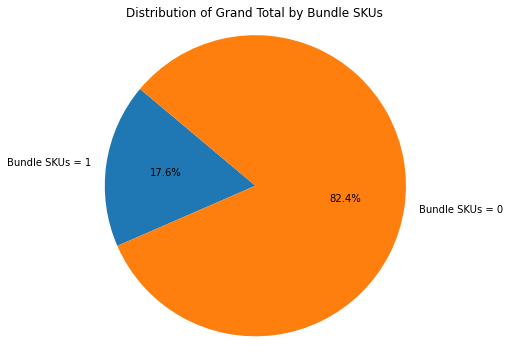

In [ ]:
import matplotlib.pyplot as plt

# Calculate the sums based on conditions
bundle_1_sum = my_data.loc[my_data['Bundle SKUs'] == 1, 'Grand Total (After Discount)'].sum()
bundle_0_sum = my_data.loc[my_data['Bundle SKUs'] == 0, 'Grand Total (After Discount)'].sum()

# Data for the pie plot
sums = [bundle_1_sum, bundle_0_sum]
labels = ['Bundle SKUs = 1', 'Bundle SKUs = 0']

# Create a pie plot
plt.figure(figsize=(6, 6))
plt.pie(sums, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Grand Total by Bundle SKUs')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Display the plot
plt.show()

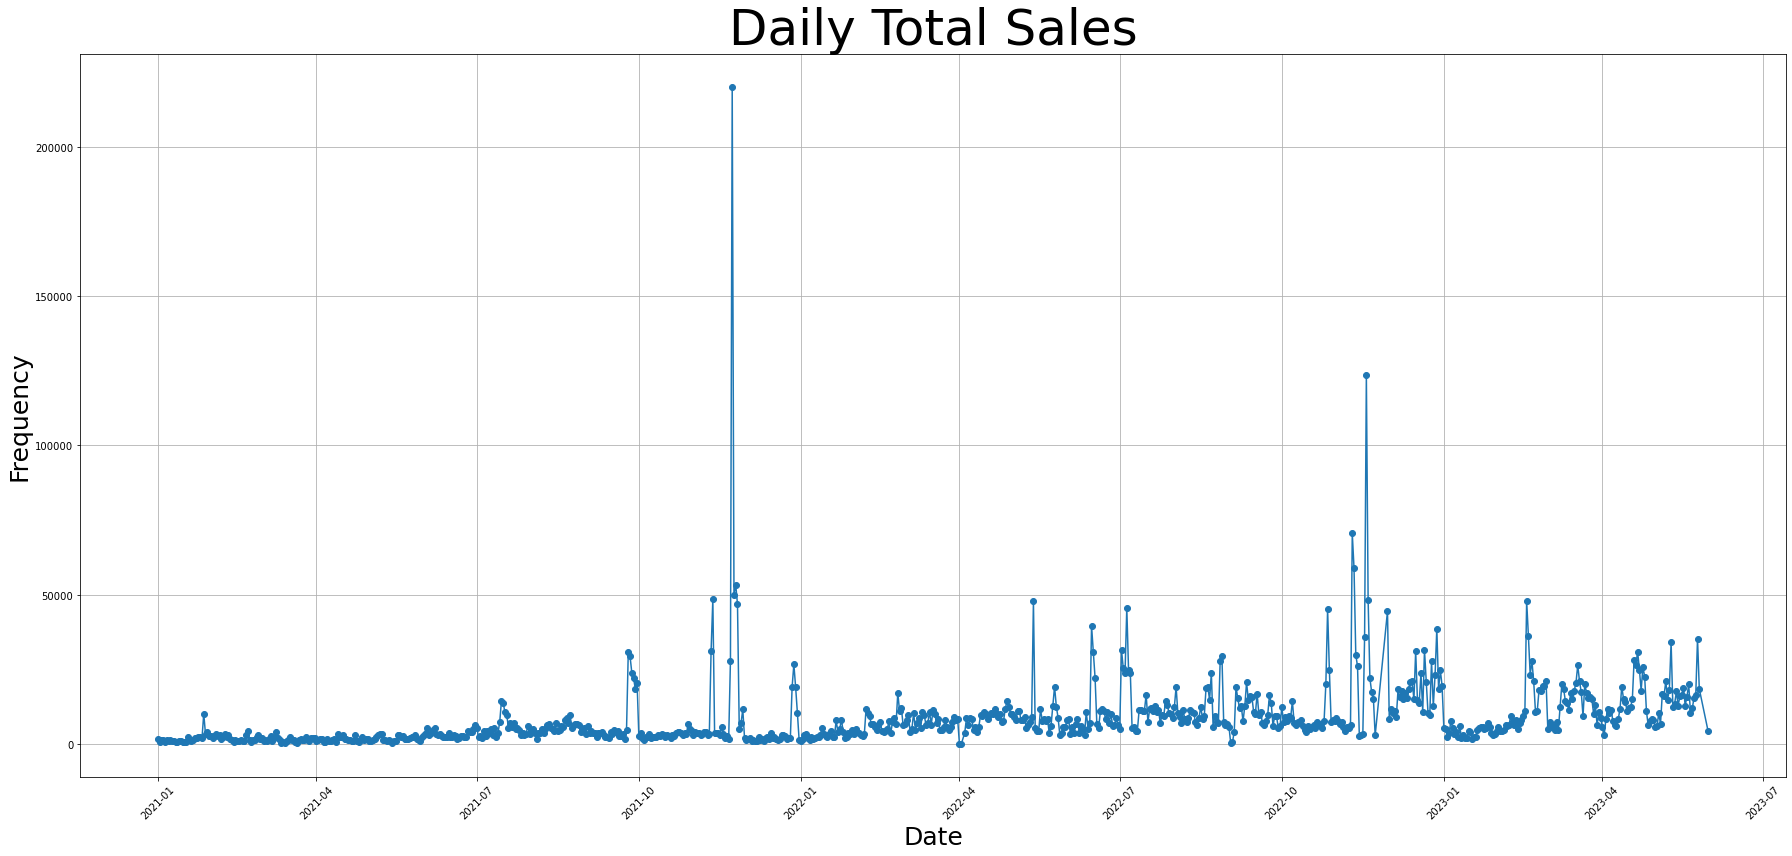

In [ ]:
# Get the frequency count of each date
date_counts = my_data.groupby('Date')['Grand Total (After Discount)'].sum()

# Sort the date_counts by the date
date_counts = date_counts.sort_index()
# Plot the results using matplotlib as a line plot
plt.figure(figsize=(25, 12))
plt.plot(date_counts.index, date_counts.values, marker='o', linestyle='-')
plt.xlabel('Date', fontsize=25)
plt.ylabel('Frequency', fontsize=25)
plt.title('Daily Total Sales', fontsize=50)
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()


In [ ]:
my_data.groupby('Date')['Grand Total (After Discount)'].sum().sort_values(ascending=False)

Date
2021-11-23    219899.35
2022-11-18    123514.79
2022-11-10     70585.91
2022-11-11     58938.46
2021-11-25     53324.92
                ...    
2021-03-14       497.18
2021-03-12       470.39
2022-09-02       301.13
2022-04-01        67.36
2022-04-02         0.00
Name: Grand Total (After Discount), Length: 870, dtype: float64

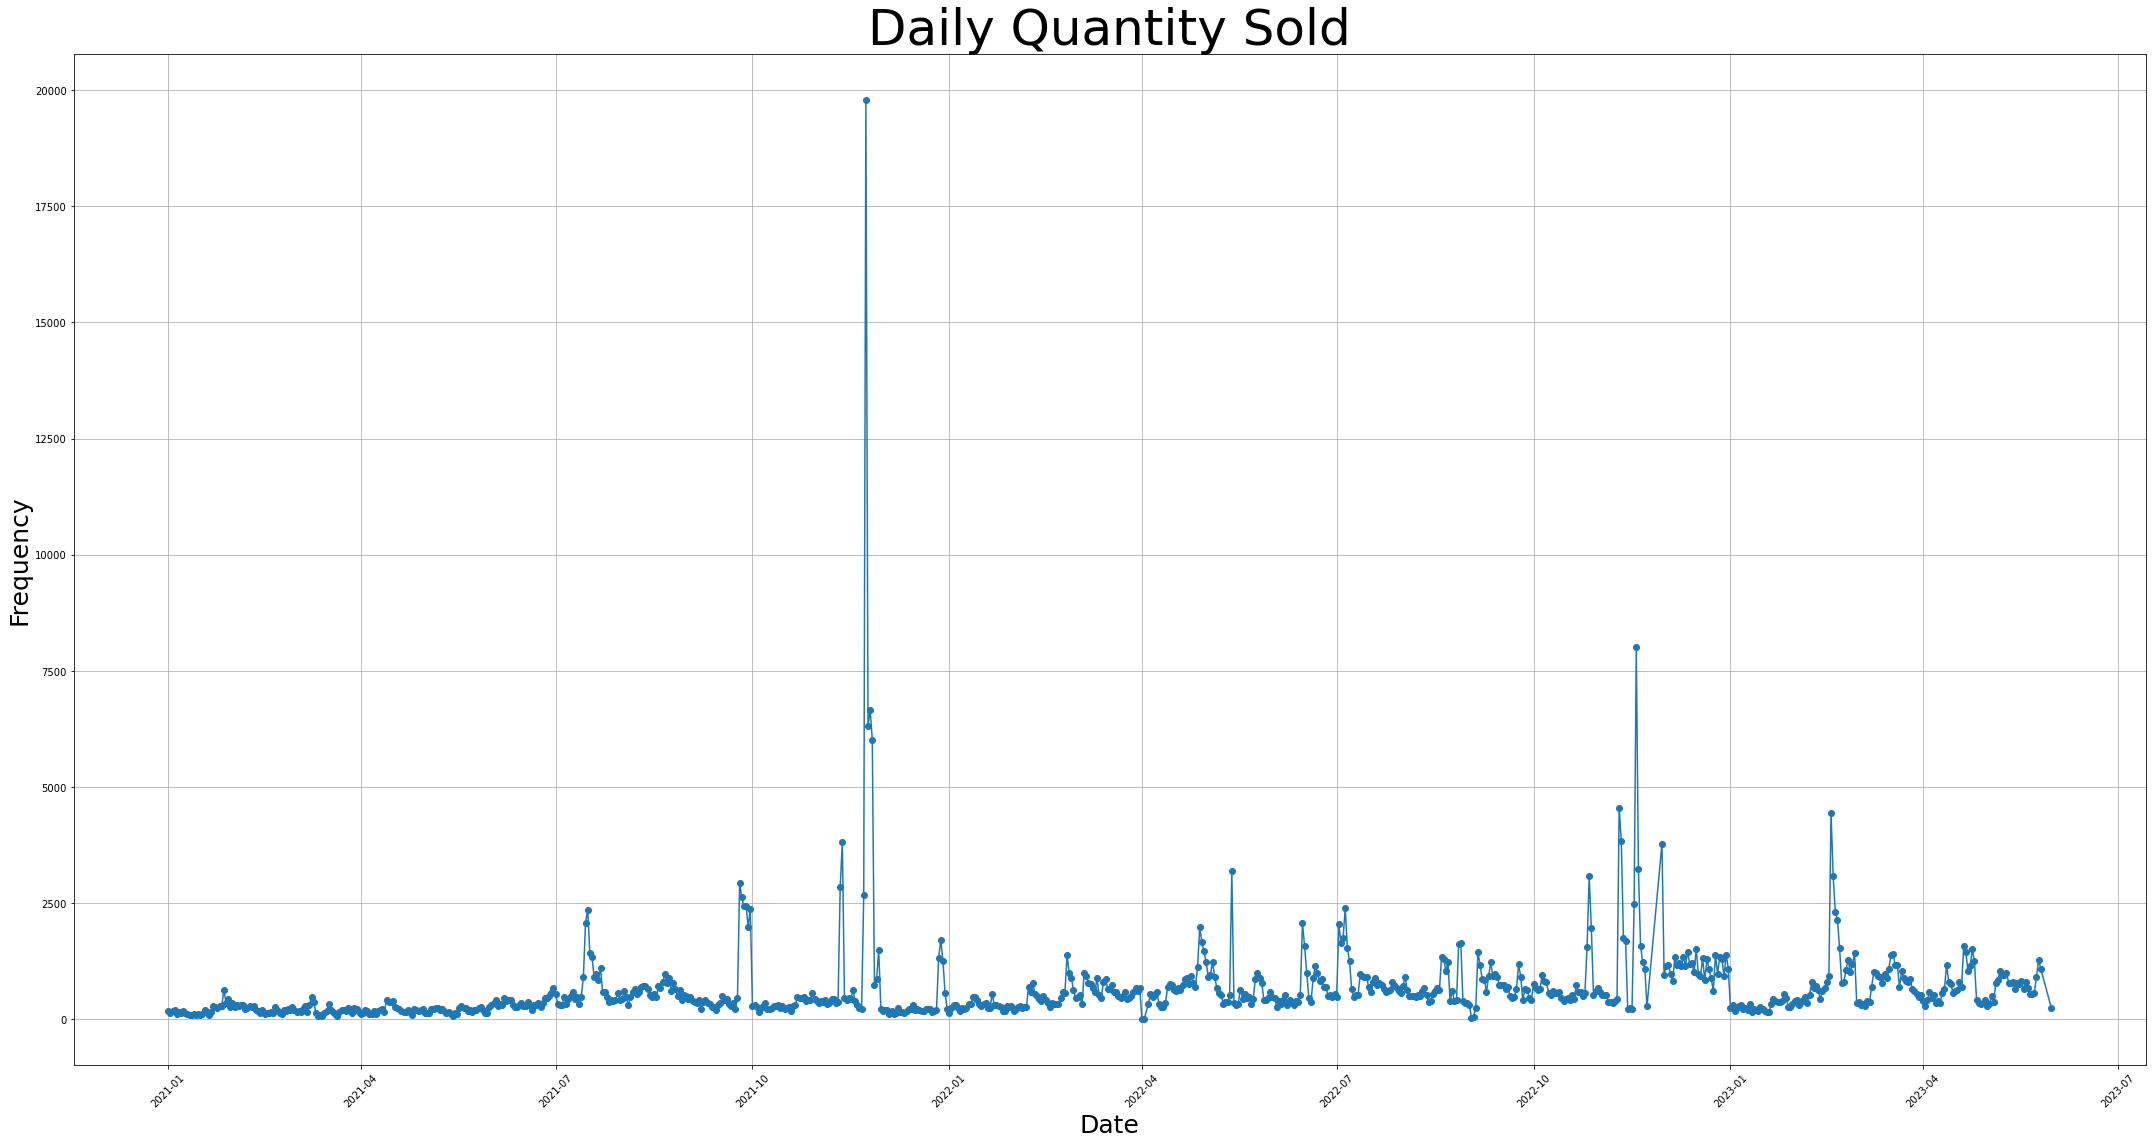

In [ ]:
# Get the frequency count of each date
date_counts = my_data.groupby('Date')['Qty Sold'].sum()

# Sort the date_counts by the date
date_counts = date_counts.sort_index()
# Plot the results using matplotlib as a line plot
plt.figure(figsize=(30, 16))
plt.plot(date_counts.index, date_counts.values, marker='o', linestyle='-')
plt.xlabel('Date', fontsize=25)
plt.ylabel('Frequency', fontsize=25)
plt.title('Daily Quantity Sold', fontsize=50)
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()


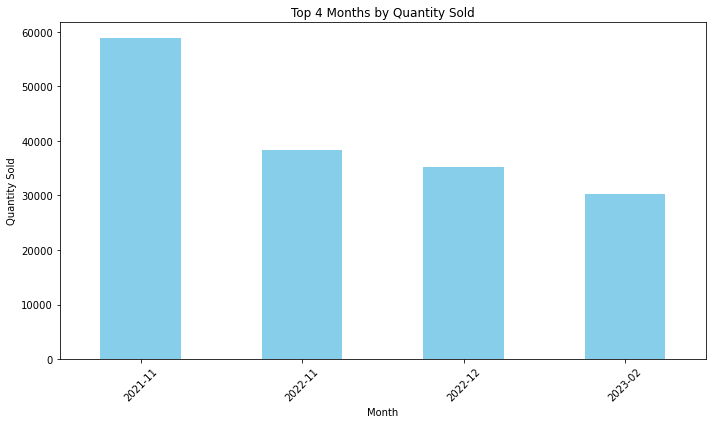

In [ ]:
# Grouping by month and summing the quantities sold, then sorting in descending order
monthly_sales = my_data.groupby(my_data['Date'].dt.to_period('M'))['Qty Sold'].sum().sort_values(ascending=False)

# Selecting the top 3 months
top_months = monthly_sales.head(4)

# Creating a bar plot for the top 3 months
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
top_months.plot(kind='bar', color='skyblue')

plt.xlabel('Month')
plt.ylabel('Quantity Sold')
plt.title('Top 4 Months by Quantity Sold')
plt.xticks(rotation=45)  # Rotating x-axis labels for better visibility

plt.tight_layout()  # Adjust spacing

plt.show()

In [ ]:
# top 10 items sold on the date with most transactions
my_data[my_data['Date']=='2021-11-23']['Item Name'].value_counts()[:10]

WHITENING ROLL-ON DEODORANT - INVISIBLE TOUCH OFFER (1+1 FREE)    1461
WHITENING ROLL-ON DEODORANT - ELDER ROSE OFFER (1+1 FREE)         1041
Lip Care Shimmery Cherry  (1+1 Free)                               701
WHITENING ROLL-ON DEODORANT - FRAGRANCE-FREE OFFER (1+1 FREE)      620
Lip Care Shimmery Strawberry  (1+1 Free)                           567
Beeswax Skin Balm  Offer - 1+1 Free                                553
WHITENING ROLL-ON DEODORANT - PACIFIC ISLANDS OFFER (1+1 FREE)     437
FEMININE HYGIENIC WASH                                             383
Lip care flavour free (1+1 Free)                                   350
ULTRASCREEN CREAM INVISIBLE SUNFILTER SPF 50                       348
Name: Item Name, dtype: int64

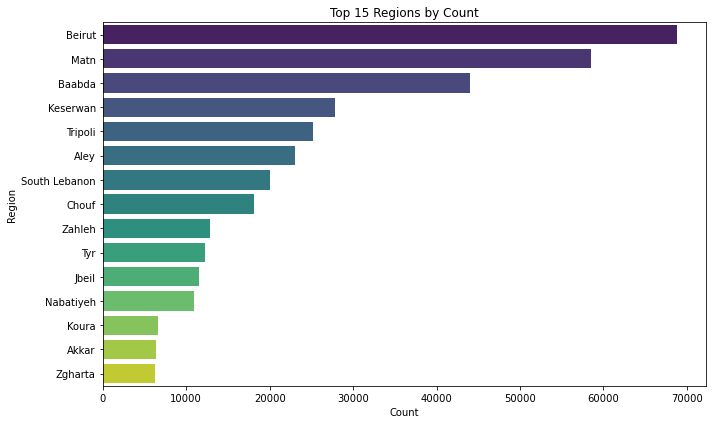

In [ ]:
# Selecting the top 15 regions by count
top_regions = my_data['Region'].value_counts().nlargest(15)

# Creating a countplot using Seaborn
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
sns.countplot(y=my_data['Region'], data=my_data, order=top_regions.index, palette='viridis')

plt.xlabel('Count')
plt.ylabel('Region')
plt.title('Top 15 Regions by Count')

plt.tight_layout()

plt.show()


In [ ]:
%%capture
!pip install tabulate

In [ ]:
from tabulate import tabulate

# Assuming my_data is your DataFrame

# Calculate the desired values
num_unique_customers = my_data['customer_id'].nunique()
num_unique_products = my_data['Item Name'].nunique()
num_unique_transactions = my_data['Order ID'].nunique()

# Prepare the data for the table
table_data = [
    ['Number of Customers', num_unique_customers],
    ['Number of Products', num_unique_products],
    ['Number of Transactions', num_unique_transactions]
]

# Create the table using tabulate
table = tabulate(table_data, headers=['Metric', 'Value'], tablefmt='grid')

# Print the table
print(table)

+------------------------+---------+
| Metric                 |   Value |
+========================+=========+
| Number of Customers    |   71921 |
+------------------------+---------+
| Number of Products     |    1556 |
+------------------------+---------+
| Number of Transactions |  130763 |
+------------------------+---------+


## The 80/20 Rule: 20% of the products are responsible for 80% of the revenue

In [22]:
data = my_data[my_data['Item Original Price'] != 0.0].copy()

# Calculate 'Total Sales' for each row (item)
data['Total Sales'] = data['Item Original Price'] * data['Qty Sold']

# Group by 'Item Name' and calculate the total sales for each item
total_sales_per_item = data.groupby('Item Name')['Total Sales'].sum().reset_index()

In [23]:
prod = total_sales_per_item.sort_values(by='Total Sales', ascending=False)
prod.reset_index(drop=True, inplace=True)
prod

,Item Name,Total Sales
0,Ultrascreen Cream Invisible Sunfilter SPF 50,29745.60
1,100% Natural Lip Balm Kit,24349.81
2,3 in 1 Micellar Cleansing Water 400ml,22646.46
3,Roll On deo Frag Free,20106.19
4,Whitening Intimate Zone Routine,19401.55
...,...,...
1297,WHITENING ROLL-ON DEODORANT ELDER ROSE (2+ FRE...,0.01
1298,WHITENING ROLL-ON DEODORANT COTTON CANDY (2+F...,0.01
1299,WHITENING ROLL-ON DEODORANT ARABIAN OUD (2+1 F...,0.01
1300,Mother's Day Moisturizing Bundle,0.01


In [24]:
print(f'Revenue percentage from top 300 ({round(300*100/1556)}%) products: ', round(100*prod['Total Sales'][:300].sum()/prod['Total Sales'].sum(), 2), '%')

Revenue percentage from top 300 (19%) products:  84.04 %


In [25]:
# for simplicity we will work with top 300 products
# which are responsible of over 80% of the revenue
prod = prod[:300]
prod

,Item Name,Total Sales
0,Ultrascreen Cream Invisible Sunfilter SPF 50,29745.60
1,100% Natural Lip Balm Kit,24349.81
2,3 in 1 Micellar Cleansing Water 400ml,22646.46
3,Roll On deo Frag Free,20106.19
4,Whitening Intimate Zone Routine,19401.55
...,...,...
295,سنسي فريش مزيل الرائحة لتفتيح المناطق الحساسة,1548.13
296,WHITENING ROLL-ON DEODORANT - SPORT PULSE OFFE...,1532.05
297,Natural Roll-On Deo - Sport Pulse (Special offer),1529.11
298,Nourishing Conditioner,1515.62


In [26]:
my_data.to_csv('cleaned_ecom_data.csv', index=False)

In [29]:
prod['Item Name'][:10].values.tolist()

['Ultrascreen Cream Invisible Sunfilter SPF 50',
 '100% Natural Lip Balm Kit',
 '3 in 1 Micellar Cleansing Water 400ml',
 'Roll On deo Frag Free',
 'Whitening Intimate Zone Routine',
 'Propolis Facial Wash',
 '4 in 1 WHITENING CLEANSER Special Offer',
 'Whitening Eye Contour Cream SPF 30',
 'Whitening Facial Cleansing Kit',
 '4 in 1 WHITENING CLEANSER']

## Price Optimization: Mathematical Approach

### What prices are optimal for maintaining demand and maximizing revenue?

#### First, we will model demand by a linear function in terms of price, for each product using historical data
#### Then, for each product we will find the optimal price based on the demand function using two methods:
####    1st: Setting manually an interval between 0 and 3 times the last price, then find the value that maximizes the revenue.
####    2nd: Using derivative of revenue function which may be not so realistic if the demand increases with price.

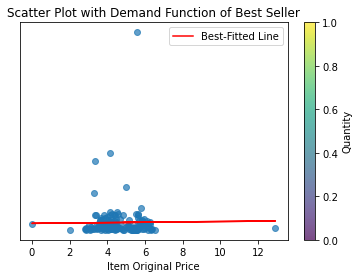

In [ ]:
from sklearn.linear_model import LinearRegression

value_counts = my_data[my_data['Item Name'] == 'Ultrascreen Cream Invisible Sunfilter SPF 50']['Item Original Price'].value_counts()
model = LinearRegression()
model.fit(np.array(value_counts.index).reshape(-1, 1), value_counts.values)
slope = model.coef_[0]
intercept = model.intercept_

X = np.array(value_counts.index).reshape(-1, 1)
plt.scatter(value_counts.index, value_counts.values, marker='o', alpha=0.7)
plt.xlabel('Item Original Price')
plt.yticks([])
plt.title('Scatter Plot with Demand Function of Best Seller')
plt.colorbar(label='Quantity')
best_fit_line = X * slope + intercept
plt.plot(value_counts.index, best_fit_line, color='red', label='Best-Fitted Line')
plt.legend()
plt.show()

In [ ]:
top_products = list(prod['Item Name'])
slopes = []
intercepts = []
last_prices = []
optimal_prices = []

for product in top_products:

    last_price = my_data[my_data['Item Name'] == product]['Item Original Price'].iloc[-1]
    if last_price == 0.0:
        last_price = my_data[my_data['Item Name'] == product]['Item Original Price'].value_counts().index[1]

    value_counts = my_data[my_data['Item Name'] == product]['Item Original Price'].value_counts()

    model = LinearRegression()
    model.fit(np.array(value_counts.index).reshape(-1, 1), value_counts.values)
    slope = model.coef_[0]
    intercept = model.intercept_

    if slope<=0:
        prices = np.linspace(0, 3*last_price, 1000)
        demands = model.predict(prices.reshape(-1,1))
        revenue = prices * demands
        optimal_price = prices[np.argmax(revenue)]
    else:
        optimal_price = 1.5*last_price



    slopes.append(slope)
    intercepts.append(intercept)
    last_prices.append(last_price)
    optimal_prices.append(optimal_price)

prod['slope'] = slopes
prod['intercept'] = intercepts
prod['last_price'] = last_prices
prod['optimal_price'] = optimal_prices
prod['% change'] = 100*(prod['optimal_price']-prod['last_price'])/prod['last_price']
prod['max_price (using derivative)'] = -prod['intercept']/(2*prod['slope'])

In [ ]:
prod

,Item Name,Total Sales,slope,intercept,last_price,optimal_price,% change,max_price (using derivative)
0,Ultrascreen Cream Invisible Sunfilter SPF 50,30538.75,0.745345,27.590357,5.58,8.370000,50.000000,-18.508448
1,100% Natural Lip Balm Kit,24666.30,-1.835609,26.804288,4.03,7.297568,81.081081,7.301198
2,3 in 1 Micellar Cleansing Water 400ml,23318.60,-64.891982,310.583487,3.69,2.393514,-35.135135,2.393081
3,Roll On deo Frag Free,20142.04,5.054758,68.262750,1.23,1.845000,50.000000,-6.752327
4,Whitening Intimate Zone Routine,19940.57,-0.395771,10.845398,11.13,13.703604,23.123123,13.701609
...,...,...,...,...,...,...,...,...
295,LIP CARE SHIMMERY CHERRY,1567.51,-10.936953,29.136140,1.16,1.330691,14.714715,1.332004
296,Natural Roll-On Deo - Sport Pulse (Special offer),1564.17,5.750210,-1.826753,4.37,6.555000,50.000000,0.158842
297,سنسي فريش مزيل الرائحة لتفتيح المناطق الحساسة,1550.85,-1.329634,10.283824,6.18,3.860180,-37.537538,3.867162
298,Facial Whitening Mask,1544.25,-7.377697,22.449618,1.34,1.521081,13.513514,1.521452


In [ ]:
print('Overall average % change in prices is: +', round(prod['% change'].mean()), '%')

Overall average % change in prices is: + 16 %


## Price Elasticity

### Why increasing prices for some products but discounting others?

In [ ]:
elasticity = []

for product in top_products:

    price = pd.unique(my_data[my_data['Item Name'] == product]['Item Original Price'])
    p1 = price[0]
    p2 = price[-1]


    qtt_1 = my_data[(my_data['Item Name'] == product) & (my_data['Item Original Price'] == p1)]['Qty Sold'].sum()
    qtt_2 = my_data[(my_data['Item Name'] == product) & (my_data['Item Original Price'] == p2)]['Qty Sold'].sum()

    qtt_perc = 100*(qtt_2 - qtt_1)/qtt_1
    price_perc = 100*(p2-p1)/p1

    elastic = abs(qtt_perc / price_perc)
    elasticity.append(elastic)


prod['elasticity'] = elasticity

In [ ]:
def is_elastic(value):
    if value > 1:
        return 'Elastic'
    elif value < 1 and value > 0:
        return 'Inelastic'
    else:
        return 'Unitary Elastic'

prod['elasticity'] = prod['elasticity'].apply(is_elastic)

In [ ]:
prod

,Item Name,Total Sales,slope,intercept,last_price,optimal_price,% change,max_price (using derivative),elasticity
0,Ultrascreen Cream Invisible Sunfilter SPF 50,30538.75,0.745345,27.590357,5.58,8.370000,50.000000,-18.508448,Inelastic
1,100% Natural Lip Balm Kit,24666.30,-1.835609,26.804288,4.03,7.297568,81.081081,7.301198,Inelastic
2,3 in 1 Micellar Cleansing Water 400ml,23318.60,-64.891982,310.583487,3.69,2.393514,-35.135135,2.393081,Inelastic
3,Roll On deo Frag Free,20142.04,5.054758,68.262750,1.23,1.845000,50.000000,-6.752327,Elastic
4,Whitening Intimate Zone Routine,19940.57,-0.395771,10.845398,11.13,13.703604,23.123123,13.701609,Inelastic
...,...,...,...,...,...,...,...,...,...
295,LIP CARE SHIMMERY CHERRY,1567.51,-10.936953,29.136140,1.16,1.330691,14.714715,1.332004,Elastic
296,Natural Roll-On Deo - Sport Pulse (Special offer),1564.17,5.750210,-1.826753,4.37,6.555000,50.000000,0.158842,Elastic
297,سنسي فريش مزيل الرائحة لتفتيح المناطق الحساسة,1550.85,-1.329634,10.283824,6.18,3.860180,-37.537538,3.867162,Unitary Elastic
298,Facial Whitening Mask,1544.25,-7.377697,22.449618,1.34,1.521081,13.513514,1.521452,Inelastic


In [ ]:
prod['elasticity'].value_counts()

Elastic            180
Inelastic           84
Unitary Elastic     36
Name: elasticity, dtype: int64

# Market Study

### Is our market ready for price change?

## Demand Forecasting

### Facebook's Prophet

### Best Seller: Ultrascreen Cream Invisible Sunfilter SPF 50

In [ ]:
from prophet import Prophet
from scipy import stats

In [ ]:
product_df = my_data[my_data['Item Name'] == 'Ultrascreen Cream Invisible Sunfilter SPF 50'].copy()

In [ ]:
product_df['Date'] = pd.to_datetime(product_df['Date'])

In [ ]:
product_df['daily_sales'] = product_df['Item Original Price'] * product_df['Qty Sold']

In [ ]:
sales_data = product_df.groupby(['Date']).agg({'daily_sales': 'sum'}).reset_index()

In [ ]:
sales_data = sales_data.rename(columns={'Date': 'ds', 'daily_sales': 'y'})

In [ ]:
sales_data

,ds,y
0,2021-12-29,96.28
1,2021-12-30,53.12
2,2021-12-31,3.32
3,2022-01-01,13.28
4,2022-01-02,3.32
...,...,...
490,2023-05-23,95.03
491,2023-05-24,111.80
492,2023-05-25,111.80
493,2023-05-26,67.08


In [ ]:
%%capture
model = Prophet()
model.fit(sales_data)

In [ ]:
future = model.make_future_dataframe(periods=365)
future.tail()

,ds
855,2024-05-26
856,2024-05-27
857,2024-05-28
858,2024-05-29
859,2024-05-30


In [ ]:
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
855,2024-05-26,129.864712,22.502807,228.210271
856,2024-05-27,133.783294,25.983884,242.074631
857,2024-05-28,129.708704,21.347266,237.409767
858,2024-05-29,129.079820,15.850947,233.939474
859,2024-05-30,135.305626,21.030165,250.614034


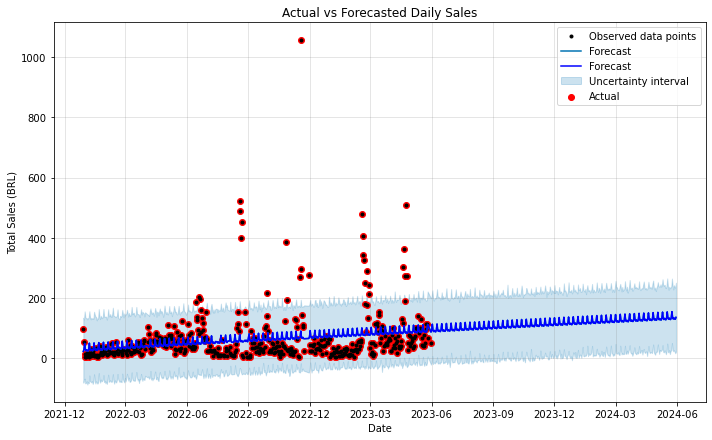

In [ ]:
# Plot the forecasted prices
fig = model.plot(forecast)
plt.scatter(sales_data['ds'], sales_data['y'], color='red', label='Actual')
plt.plot(forecast['ds'], forecast['yhat'], color='blue', label='Forecast')
plt.title('Actual vs Forecasted Daily Sales')
plt.xlabel('Date')
plt.ylabel('Total Sales (BRL)')
plt.legend()
plt.show()

In [ ]:
new_average = round(forecast['yhat'].tail(365).mean(),2)
old_average = round(forecast['yhat'][:-365].mean(),2)
print(f'Daily Sales for "Ultrascreen Cream Invisible Sunfilter SPF 50" will increase from {old_average}$ per day to {new_average}$ per day!')

Daily Sales for "Ultrascreen Cream Invisible Sunfilter SPF 50" will increase from 61.69$ per day to 114.2$ per day!


### Implementation for top 10 products!

In [ ]:
%%capture
forecast_models = {}

for product in top_products[:10]:
    product_df = my_data[my_data['Item Name'] == product].copy()
    product_df['daily_sales'] = product_df['Item Original Price'] * product_df['Qty Sold']
    sales_data = product_df.groupby(['Date']).agg({'daily_sales': 'sum'}).reset_index()
    sales_data = sales_data.rename(columns={'Date': 'ds', 'daily_sales': 'y'})
    model = Prophet()
    model.fit(sales_data)
    forecast_models[product] = model

In [ ]:
avg_sales_next_year = []
for product in forecast_models:
    m = forecast_models[product]
    future = m.make_future_dataframe(periods=365)
    forecast = m.predict(future)
    future_prices = forecast[['ds', 'yhat']].tail(365)
    mean_price = future_prices['yhat'].mean()
    avg_sales_next_year.append(mean_price)

In [ ]:
avg_sales_next_year

[114.19528307554728,
 224.9869943815156,
 -212.99913965456554,
 188.06239083835905,
 71.41627109350227,
 -15.24436015696102,
 -42.71030569438999,
 -15.51597228060975,
 63.655837313102,
 -16.350222357865682]

### Predict Average Sales Next Year

In [ ]:
# Aggregate sales data by date

sales_data = my_data.groupby(['Date']).agg({'Grand Total (After Discount)': 'sum'}).reset_index()
sales_data = sales_data.rename(columns={'Date': 'ds', 'Grand Total (After Discount)': 'y'})

# Remove outliers from sales data using Z-score
sales_data = sales_data[(np.abs(stats.zscore(sales_data['y'])) < 1.5)]

# Train a time series forecasting model
m = Prophet()
m.fit(sales_data)

# Create a future dataframe for forecasting
future = m.make_future_dataframe(periods=365)

# Use the model to make price predictions for each day in the future
forecast = m.predict(future)

# Extract the forecasted prices
forecasted_prices = forecast[['ds', 'yhat']].tail(365)

In [ ]:
avg = forecasted_prices['yhat'].mean()
print(f'On average, daily sales will attain around {round(avg,2)}$ next year!')

On average, daily sales will attain around 15920.07$ next year!


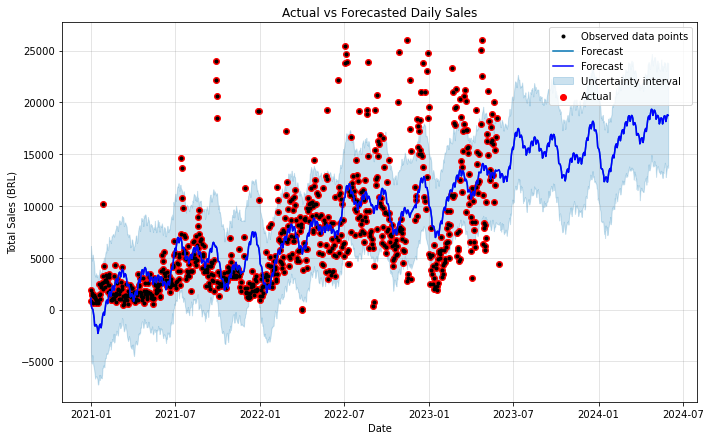

In [ ]:
# Plot the forecasted prices
fig = m.plot(forecast)
plt.scatter(sales_data['ds'], sales_data['y'], color='red', label='Actual')
plt.plot(forecast['ds'], forecast['yhat'], color='blue', label='Forecast')
plt.title('Actual vs Forecasted Daily Sales')
plt.xlabel('Date')
plt.ylabel('Total Sales (BRL)')
plt.legend()
plt.show()

## Customer Segmentation

### Build a unique profile for each customer based on spending behavior and geolocation features

In [ ]:
orders_per_customer = my_data.groupby('customer_id')['Order ID'].nunique()
customers = pd.DataFrame({'customer_id': orders_per_customer.index, 'Orders Count': orders_per_customer.values})
customers['Qtt Purchased'] = my_data.groupby('customer_id').agg({'Qty Sold': 'sum'}).values
customers['Total Spending'] = my_data.groupby('customer_id').agg({'Grand Total (After Discount)': 'sum'}).values
customers

,customer_id,Orders Count,Qtt Purchased,Total Spending
0,100001,1,1,4.46
1,100004,3,10,58.27
2,100005,1,1,4.46
3,100007,7,33,415.96
4,100008,12,44,352.31
...,...,...,...,...
71916,186451,1,5,89.10
71917,186452,1,6,73.14
71918,186486,1,13,394.98
71919,186490,1,5,114.35


In [ ]:
test  =  my_data[['Region', 'customer_id']].drop_duplicates()
test['customer_id'].value_counts()

100148    88
102139    15
107934    14
100412     9
104610     7
          ..
133038     1
133039     1
133040     1
133042     1
186492     1
Name: customer_id, Length: 71921, dtype: int64

In [ ]:
# Group data by customer
grouped = test.groupby('customer_id')

# Create a new DataFrame to store the most frequent region for each customer
most_frequent_regions = pd.DataFrame(columns=['customer_id', 'most_frequent_region'])

# Iterate through each customer group
for customer_id, group in grouped:
    # Calculate the frequency of each region in the customer's addresses
    region_counts = group['Region'].value_counts()

    # Get the most frequent region (first index after sorting by frequency)
    most_frequent_region = region_counts.idxmax()

    # Append the result to the new DataFrame
    most_frequent_regions = most_frequent_regions.append({'customer_id': customer_id, 'most_frequent_region': most_frequent_region}, ignore_index=True)

most_frequent_regions

,customer_id,most_frequent_region
0,100001,Mont liban
1,100004,Saraain El Faouqa Baalbeck
2,100005,MARJAYOUN
3,100007,Mount lebanon
4,100008,Chouf
...,...,...
71916,186451,Tripoli
71917,186452,Beirut
71918,186486,Jbeil
71919,186490,Beirut


In [ ]:
customers = pd.merge(customers, most_frequent_regions, on='customer_id', how='left')
customers = pd.merge(customers, my_data[['customer_id', 'Country']].drop_duplicates(), on='customer_id', how='left')
customers

,customer_id,Orders Count,Qtt Purchased,Total Spending,most_frequent_region,Country
0,100001,1,1,4.46,Mont liban,Lebanon
1,100004,3,10,58.27,Saraain El Faouqa Baalbeck,Lebanon
2,100005,1,1,4.46,MARJAYOUN,Lebanon
3,100007,7,33,415.96,Mount lebanon,Lebanon
4,100008,12,44,352.31,Chouf,Lebanon
...,...,...,...,...,...,...
71944,186451,1,5,89.10,Tripoli,Lebanon
71945,186452,1,6,73.14,Beirut,Lebanon
71946,186486,1,13,394.98,Jbeil,Lebanon
71947,186490,1,5,114.35,Beirut,Lebanon


In [ ]:
def to_binary(value):
    if value == 0.0:
        return 1
    return 0

In [ ]:
my_data['Item Discounted Price'] = my_data['Item Discounted Price'].apply(to_binary)
my_data['Shipping Fees'] = my_data['Shipping Fees'].apply(to_binary)

In [ ]:
# for simplicity working with 5000 customers
customers = customers.sample(n=5000, random_state=1)

In [ ]:
fav_cat = []
avg_price_by_cat = []
choose_bundle = []
choose_discount = []
pay_ship_fees = []

for cust_id in list(customers['customer_id'].values):
    category = my_data[my_data['customer_id'] == cust_id]['Category'].value_counts().idxmax()
    avg_price = my_data.groupby('Category').get_group(category)['Item Original Price'].mean()
    bundle = my_data[my_data['customer_id'] == cust_id]['Bundle SKUs'].value_counts().idxmax()
    discount = my_data[my_data['customer_id'] == cust_id]['Item Discounted Price'].value_counts().idxmax()
    fees = my_data[my_data['customer_id'] == cust_id]['Shipping Fees'].value_counts().idxmax()

    fav_cat.append(category)
    avg_price_by_cat.append(avg_price)
    choose_bundle.append(bundle)
    choose_discount.append(discount)
    pay_ship_fees.append(fees)

customers['Favorite Category'] = fav_cat
customers['Average Price per Category'] = avg_price_by_cat
customers['Choose Bundle'] = choose_bundle
customers['Choose Discount'] = choose_discount
customers['Pay Shipping Fees'] = pay_ship_fees

customers

,customer_id,Orders Count,Qtt Purchased,Total Spending,most_frequent_region,Country,Favorite Category,Average Price per Category,Choose Bundle,Choose Discount,Pay Shipping Fees
12681,116307,3,4,15.68,Tripoli,Lebanon,"Skin Whitening,View All Products,Deodorants,Un...",3.205315,0,1,0
42242,147782,1,3,0.03,Sharjah,United Arab Emirates,"Skin Whitening,Bundles & Offers,Intimate Hygiene",3.382276,1,1,1
45950,151623,1,2,19.80,Matn,Lebanon,"Skin Treatments,View All Products,30% Discount...",1.832846,0,1,0
31964,136886,1,1,6.02,Zgharta,Lebanon,"Bundles & Offers,Deodorants,UniSex,Single's Da...",4.233774,1,1,0
36978,142290,1,2,1.50,Baghdad,Iraq,"Skin Whitening,View All Products,Deodorants,Ne...",2.964549,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...
70997,185247,1,4,48.64,Beirut,Lebanon,"Bundles & Saves,Micellar Water",3.750570,0,1,1
26417,131068,2,10,52.68,Akkar,Lebanon,"Skin Treatments,Bundles & Offers,Yellow Week Sale",3.590092,0,1,1
63256,173165,1,3,25.83,Baabda,Lebanon,"Face Care,View All Products,40% Discount,Yello...",5.506735,0,1,0
12075,115663,3,24,248.90,Tyr,Lebanon,"Express,View All Products,Yellow Week Sale",0.849269,0,1,1


In [ ]:
customers.to_csv('customers_data.csv')

In [31]:
customers = pd.read_csv(r"C:\Users\USER\Downloads\Data\Data\System 2021-2023\customers_data.csv")

In [32]:
#from langdetect import detect
import re
import string

def clean_text(text):

    # Replace commas with spaces
    text = text.replace(',', ' ')

    # Convert to lowercase
    text = text.lower()

    # Remove punctuation (excluding commas) using regex
    text =text = re.sub(r'[^a-zA-Z0-9\s]', '', text)

    # Remove extra whitespace
    text = re.sub('\s+',' ', text).strip()

    return text

def is_english(text):
    try:
        return detect(text) == 'en'
    except:
        return False


def replace_non_english_with_placeholder(df, column_name):
    english_rows = df[df[column_name].apply(is_english)]

    # Replace non-English rows with placeholders like "product 1", "product 2", etc.
    product_counter = 1
    for index, row in df.iterrows():
        if not is_english(row[column_name]):
            df.at[index, column_name] = f"product {product_counter}"
            product_counter += 1

    return df


In [33]:
#customers['is_english'] = customers['Favorite Category'].apply(is_english)
customers['Favorite Category'] = customers['Favorite Category'].apply(clean_text)

In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer


# Initialize the TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()
tfidf_vectorizer.fit(customers['Favorite Category'])

# Fit and transform the text data
tfidf_matrix = tfidf_vectorizer.fit_transform(customers['Favorite Category'])

# Convert the TF-IDF matrix to an array
tfidf_array = tfidf_matrix.toarray()

# Print the vocabulary (words)
vocabulary = tfidf_vectorizer.get_feature_names_out()
print("Vocabulary:", vocabulary)

# Print the TF-IDF matrix
print("TF-IDF Matrix:\n", tfidf_array)


Vocabulary: ['11' '30' '35' '40' '50' 'all' 'balms' 'beesline' 'body' 'bright'
 'brightening' 'bundles' 'care' 'category' 'creams' 'day' 'deodorants'
 'discount' 'essentials' 'express' 'face' 'free' 'gift' 'hair' 'hygiene'
 'instant' 'intimate' 'lip' 'masks' 'men' 'micellar' 'new' 'offers'
 'products' 'radiance' 'releases' 'sale' 'saves' 'shower' 'singles' 'skin'
 'spf' 'sun' 'treatments' 'unisex' 'view' 'water' 'week' 'whitening'
 'women' 'yellow']
TF-IDF Matrix:
 [[0.         0.         0.         ... 0.30875853 0.         0.20595947]
 [0.         0.         0.         ... 0.35400658 0.         0.        ]
 [0.         0.61208774 0.         ... 0.         0.         0.19110954]
 ...
 [0.         0.         0.         ... 0.         0.         0.24710304]
 [0.         0.         0.         ... 0.         0.         0.2942421 ]
 [0.         0.         0.         ... 0.         0.         0.23914282]]


In [36]:
import pickle

with open('tfidf_vectorizer.pkl', 'wb') as file:
    pickle.dump(tfidf_vectorizer, file)

In [62]:
nested_list = tfidf_vectorizer.transform(['skin whitening']).toarray()

In [43]:
customers.columns

Index(['Unnamed: 0', 'customer_id', 'Orders Count', 'Qtt Purchased',
       'Total Spending', 'most_frequent_region', 'Country',
       'Favorite Category', 'Average Price per Category', 'Choose Bundle',
       'Choose Discount', 'Pay Shipping Fees'],
      dtype='object')

In [44]:
customers.drop(['Unnamed: 0', 'customer_id', 'most_frequent_region', 'Country', 'Pay Shipping Fees', 'Average Price per Category'], axis=1, inplace=True)

In [45]:
# Convert the TF-IDF matrix to a DataFrame
tfidf_df = pd.DataFrame(tfidf_array, columns=vocabulary)

# Concatenate the original DataFrame and the TF-IDF DataFrame
cust_df = pd.concat([customers, tfidf_df], axis=1)

In [46]:
cust_df

,Orders Count,Qtt Purchased,Total Spending,Favorite Category,Choose Bundle,Choose Discount,11,30,35,40,50,all,balms,beesline,body,bright,brightening,bundles,care,category,creams,day,deodorants,discount,essentials,express,face,free,gift,hair,hygiene,instant,intimate,lip,masks,men,micellar,new,offers,products,radiance,releases,sale,saves,shower,singles,skin,spf,sun,treatments,unisex,view,water,week,whitening,women,yellow
0,3,4,15.68,skin whitening view all products deodorants un...,0,1,0.0,0.000000,0.0,0.000000,0.353184,0.215602,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.354257,0.257490,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.211426,0.0,0.000000,0.205959,0.000000,0.0,0.000000,0.281558,0.0,0.000000,0.000000,0.493890,0.215602,0.000000,0.205959,0.308759,0.0,0.205959
1,1,3,0.03,skin whitening bundles offers intimate hygiene,1,1,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.322096,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.537679,0.0,0.525297,0.0,0.0,0.000000,0.000000,0.000000,0.318882,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.322819,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.354007,0.0,0.000000
2,1,2,19.80,skin treatments view all products 30 discount ...,0,1,0.0,0.612088,0.0,0.000000,0.000000,0.200057,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.238925,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.196182,0.0,0.000000,0.191110,0.000000,0.0,0.000000,0.261257,0.0,0.000000,0.521447,0.000000,0.200057,0.000000,0.191110,0.000000,0.0,0.191110
3,1,1,6.02,bundles offers deodorants unisex singles day o...,1,1,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.257918,0.000000,0.0,0.0,0.356385,0.325242,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.510689,0.000000,0.0,0.000000,0.189091,0.000000,0.0,0.356385,0.000000,0.0,0.000000,0.000000,0.453439,0.000000,0.000000,0.189091,0.000000,0.0,0.189091
4,1,2,1.50,skin whitening view all products deodorants ne...,0,1,0.0,0.000000,0.0,0.000000,0.279113,0.170386,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.279962,0.203489,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.491042,0.000000,0.339897,0.000000,0.167086,0.0,0.413704,0.162765,0.000000,0.0,0.000000,0.222509,0.0,0.000000,0.000000,0.000000,0.170386,0.000000,0.162765,0.244005,0.0,0.162765
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,1,4,48.64,bundles saves micellar water,0,1,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.226691,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.583227,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.517981,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.583227,0.000000,0.000000,0.0,0.000000
4996,2,10,52.68,skin treatments bundles offers yellow week sale,0,1,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.341023,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.337620,0.000000,0.0,0.000000,0.250018,0.000000,0.0,0.000000,0.341788,0.0,0.000000,0.682180,0.000000,0.000000,0.000000,0.250018,0.000000,0.0,0.250018
4997,1,3,25.83,face care view all products 40 discount yellow...,0,1,0.0,0.000000,0.0,0.470558,0.000000,0.258672,0.0,0.0,0.0,0.0,0.0,0.000000,0.393522,0.0,0.0,0.000000,0.000000,0.308928,0.0,0.000000,0.383317,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.253662,0.0,0.000000,0.247103,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.258672,0.00

In [8]:
# Replace 'N' with the number of top categories you want to keep
N = 10

# Get the top N most frequent categories in 'category_column'
top_categories = cust_df['most_frequent_region'].value_counts().nlargest(N).index

# Create a new column 'category_encoded' where top N categories are encoded, and the rest are labeled as 'Other'
cust_df['most_frequent_region'] = cust_df['most_frequent_region'].apply(lambda x: x if x in top_categories else 'Other')

In [9]:
categorical_columns = ['most_frequent_region', 'Country']

# Perform one-hot encoding with drop_first=True
encoded_df = pd.get_dummies(cust_df, columns=categorical_columns, drop_first=True)

In [10]:
encoded_df.shape

(5000, 78)

In [47]:
cust_df.drop(['Favorite Category'], axis=1, inplace=True)

In [13]:
encoded_df.duplicated().value_counts()

False    4721
True      279
dtype: int64

In [14]:
encoded_df.isna().sum()

Orders Count                    0
Qtt Purchased                   0
Total Spending                  0
Average Price per Category      0
Choose Bundle                   0
                               ..
Country_Kuwait                  0
Country_Lebanon                 0
Country_Qatar                   0
Country_Saudi Arabia            0
Country_United Arab Emirates    0
Length: 75, dtype: int64

In [48]:
cust_df.drop_duplicates(inplace=True)
cust_df.reset_index(drop=True, inplace=True)

In [ ]:
encoded_df

,Orders Count,Qtt Purchased,Total Spending,Average Price per Category,Choose Bundle,Choose Discount,Pay Shipping Fees,11,30,35,40,50,all,balms,beesline,body,bright,brightening,bundles,care,category,creams,day,deodorants,discount,essentials,express,face,free,gift,hair,hygiene,instant,intimate,lip,masks,men,micellar,new,offers,products,radiance,releases,sale,saves,shower,singles,skin,spf,sun,treatments,unisex,view,water,week,whitening,women,yellow,most_frequent_region_Baabda,most_frequent_region_Beirut,most_frequent_region_Chouf,most_frequent_region_Keserwan,most_frequent_region_Matn,most_frequent_region_Nabatiyeh,most_frequent_region_Other,most_frequent_region_South Lebanon,most_frequent_region_Tripoli,most_frequent_region_Tyr,Country_Iraq,Country_Jordan,Country_Kuwait,Country_Lebanon,Country_Qatar,Country_Saudi Arabia,Country_United Arab Emirates
0,3,4,15.68,3.205315,0,1,0,0.0,0.000000,0.0,0.000000,0.353184,0.215602,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.354257,0.257490,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.211426,0.0,0.000000,0.205959,0.000000,0.0,0.000000,0.281558,0.0,0.000000,0.000000,0.493890,0.215602,0.000000,0.205959,0.308759,0.0,0.205959,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0
1,1,3,0.03,3.382276,1,1,1,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.322096,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.537679,0.0,0.525297,0.0,0.0,0.000000,0.000000,0.000000,0.318882,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.322819,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.354007,0.0,0.000000,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
2,1,2,19.80,1.832846,0,1,0,0.0,0.612088,0.0,0.000000,0.000000,0.200057,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.238925,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.196182,0.0,0.000000,0.191110,0.000000,0.0,0.000000,0.261257,0.0,0.000000,0.521447,0.000000,0.200057,0.000000,0.191110,0.000000,0.0,0.191110,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0
3,1,1,6.02,4.233774,1,1,0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.257918,0.000000,0.0,0.0,0.356385,0.325242,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.510689,0.000000,0.0,0.000000,0.189091,0.000000,0.0,0.356385,0.000000,0.0,0.000000,0.000000,0.453439,0.000000,0.000000,0.189091,0.000000,0.0,0.189091,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
4,1,2,1.50,2.964549,0,1,1,0.0,0.000000,0.0,0.000000,0.279113,0.170386,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.279962,0.203489,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.491042,0.000000,0.339897,0.000000,0.167086,0.0,0.413704,0.162765,0.000000,0.0,0.000000,0.222509,0.0,0.000000,0.000000,0.000000,0.170386,0.000000,0.162765,0.244005,0.0,0.162765,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4716,1,4,48.64,3.750570,0,1,1,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.226691,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.583227,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.517981,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.583227,0.000000,0.000000,0.0,0.000000,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4717,2,10,52.68,3.590092,0,1,1,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.341023,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.337620,0.000000,0.0,0.000000,0.250018,0.000000,0.0,0.000000,0.341788,0.0,0.0

Text(0, 0.5, 'Cumulative Explained Variance')

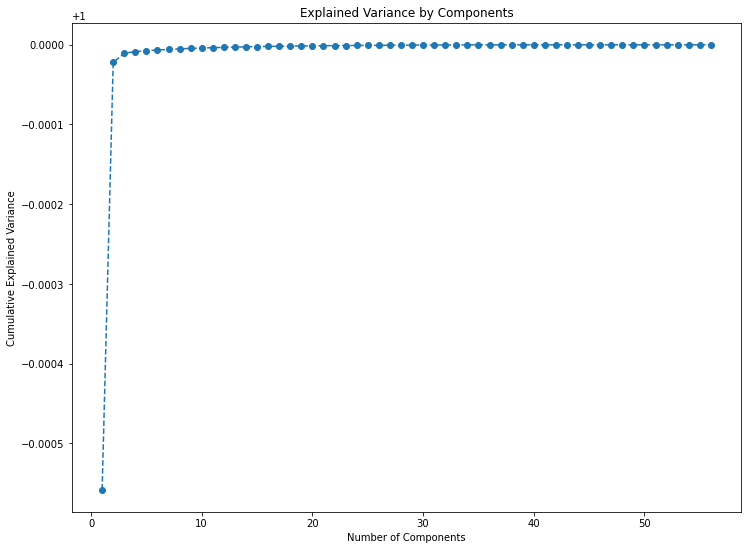

In [51]:
pca = PCA()
pca.fit(cust_df)
plt.figure(figsize = (12,9))
plt.plot(range(1,57), pca.explained_variance_ratio_.cumsum(), marker = 'o', linestyle = '--')
plt.title('Explained Variance by Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')

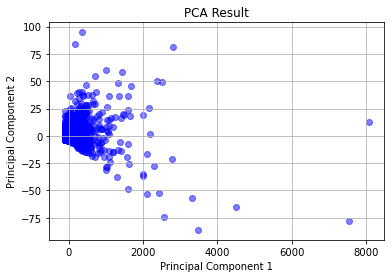

In [52]:
# Assuming 'X' is your feature matrix (without the target variable)
pca = PCA(n_components=2)  # You can choose the number of components (e.g., 2 for 2D visualization)
principal_components = pca.fit_transform(cust_df)

# Create a DataFrame for the principal components
principal_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

# Scatter plot the principal components
plt.scatter(principal_df['PC1'], principal_df['PC2'], c='b', marker='o', alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Result')
plt.grid()
plt.show()

In [59]:
pca.fit(cust_df)
with open('pca_model.pkl', 'wb') as file:
    pickle.dump(pca, file)

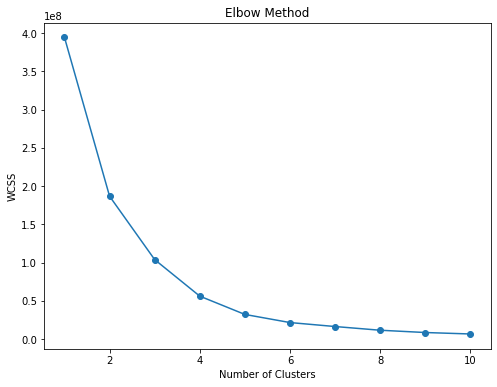

In [53]:
from sklearn.cluster import KMeans

# Calculate WCSS for different numbers of clusters
wcss = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(principal_components)
    wcss.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

In [89]:
cust_df

,Orders Count,Qtt Purchased,Total Spending,Choose Bundle,Choose Discount,11,30,35,40,50,all,balms,beesline,body,bright,brightening,bundles,care,category,creams,day,deodorants,discount,essentials,express,face,free,gift,hair,hygiene,instant,intimate,lip,masks,men,micellar,new,offers,products,radiance,releases,sale,saves,shower,singles,skin,spf,sun,treatments,unisex,view,water,week,whitening,women,yellow,cluster,Labels
0,3,4,15.68,0,1,0.0,0.000000,0.0,0.000000,0.353184,0.215602,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.354257,0.257490,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.211426,0.0,0.000000,0.205959,0.000000,0.0,0.000000,0.281558,0.0,0.0,0.000000,0.493890,0.215602,0.000000,0.205959,0.308759,0.0,0.205959,1,1
1,1,3,0.03,1,1,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.322096,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.537679,0.0,0.525297,0.0,0.0,0.000000,0.000000,0.000000,0.318882,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.322819,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.354007,0.0,0.000000,0,0
2,1,2,19.80,0,1,0.0,0.612088,0.0,0.000000,0.000000,0.200057,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.238925,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.196182,0.0,0.000000,0.191110,0.000000,0.0,0.000000,0.261257,0.0,0.0,0.521447,0.000000,0.200057,0.000000,0.191110,0.000000,0.0,0.191110,1,1
3,1,1,6.02,1,1,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.257918,0.000000,0.0,0.0,0.356385,0.325242,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.510689,0.000000,0.0,0.000000,0.189091,0.000000,0.0,0.356385,0.000000,0.0,0.0,0.000000,0.453439,0.000000,0.000000,0.189091,0.000000,0.0,0.189091,0,0
4,1,2,1.50,0,1,0.0,0.000000,0.0,0.000000,0.279113,0.170386,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.279962,0.203489,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.491042,0.000000,0.339897,0.000000,0.167086,0.0,0.413704,0.162765,0.000000,0.0,0.000000,0.222509,0.0,0.0,0.000000,0.000000,0.170386,0.000000,0.162765,0.244005,0.0,0.162765,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4610,2,4,24.56,1,0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.331487,0.387031,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.559742,0.376994,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.328179,0.000000,0.0,0.000000,0.243027,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.243027,0.000000,0.0,0.243027,0,0
4611,1,4,48.64,0,1,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.226691,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.583227,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.517981,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.583227,0.000000,0.000000,0.0,0.000000,0,0
4612,2,10,52.68,0,1,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.341023,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.337620,0.000000,0.0,0.000000,0.250018,0.000000,0.0,0.000000,0.341788,0.0,0.0,0.682180,0.000000,0.000000,0.000000,0.250018,0.000000,0.0,0.250018,0,0
4613,1,3,25.83,0,1,0.0,0.000000,0.0,0.470558,0.000000,0.258672,0.0,0.0,0.0,0.0,0.0,0.000000,0.393522,0.0,0.0,0.000000,0.000000,0.308928,0.0,0.000000,0.383317,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.253662,0.0,0.000000,0.247103,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.258672,0.000000,0.2

In [90]:
cust_df.drop(['cluster', 'Labels'], axis=1, inplace=True)
cust_df.shape

(4615, 56)

In [84]:
# Initialize the standard scaler
scaler = StandardScaler()

# Initialize the KMeans clustering model
kmeans = KMeans(n_clusters=2, random_state=42)


# Create the pipeline
pipeline = Pipeline([
    ('scaler', scaler),
    ('kmeans', kmeans)
])

# Fit and transform the data through the pipeline
cluster_labels = pipeline.fit_predict(cust_df)

# Add the cluster labels to the DataFrame
cust_df['cluster'] = cluster_labels

cust_df

,Orders Count,Qtt Purchased,Total Spending,Choose Bundle,Choose Discount,11,30,35,40,50,all,balms,beesline,body,bright,brightening,bundles,care,category,creams,day,deodorants,discount,essentials,express,face,free,gift,hair,hygiene,instant,intimate,lip,masks,men,micellar,new,offers,products,radiance,releases,sale,saves,shower,singles,skin,spf,sun,treatments,unisex,view,water,week,whitening,women,yellow,cluster
0,3,4,15.68,0,1,0.0,0.000000,0.0,0.000000,0.353184,0.215602,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.354257,0.257490,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.211426,0.0,0.000000,0.205959,0.000000,0.0,0.000000,0.281558,0.0,0.0,0.000000,0.493890,0.215602,0.000000,0.205959,0.308759,0.0,0.205959,1
1,1,3,0.03,1,1,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.322096,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.537679,0.0,0.525297,0.0,0.0,0.000000,0.000000,0.000000,0.318882,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.322819,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.354007,0.0,0.000000,0
2,1,2,19.80,0,1,0.0,0.612088,0.0,0.000000,0.000000,0.200057,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.238925,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.196182,0.0,0.000000,0.191110,0.000000,0.0,0.000000,0.261257,0.0,0.0,0.521447,0.000000,0.200057,0.000000,0.191110,0.000000,0.0,0.191110,1
3,1,1,6.02,1,1,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.257918,0.000000,0.0,0.0,0.356385,0.325242,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.510689,0.000000,0.0,0.000000,0.189091,0.000000,0.0,0.356385,0.000000,0.0,0.0,0.000000,0.453439,0.000000,0.000000,0.189091,0.000000,0.0,0.189091,0
4,1,2,1.50,0,1,0.0,0.000000,0.0,0.000000,0.279113,0.170386,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.279962,0.203489,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.491042,0.000000,0.339897,0.000000,0.167086,0.0,0.413704,0.162765,0.000000,0.0,0.000000,0.222509,0.0,0.0,0.000000,0.000000,0.170386,0.000000,0.162765,0.244005,0.0,0.162765,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4610,2,4,24.56,1,0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.331487,0.387031,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.559742,0.376994,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.328179,0.000000,0.0,0.000000,0.243027,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.243027,0.000000,0.0,0.243027,0
4611,1,4,48.64,0,1,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.226691,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.583227,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.517981,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.583227,0.000000,0.000000,0.0,0.000000,0
4612,2,10,52.68,0,1,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.341023,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.337620,0.000000,0.0,0.000000,0.250018,0.000000,0.0,0.000000,0.341788,0.0,0.0,0.682180,0.000000,0.000000,0.000000,0.250018,0.000000,0.0,0.250018,0
4613,1,3,25.83,0,1,0.0,0.000000,0.0,0.470558,0.000000,0.258672,0.0,0.0,0.0,0.0,0.0,0.000000,0.393522,0.0,0.0,0.000000,0.000000,0.308928,0.0,0.000000,0.383317,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.253662,0.0,0.000000,0.247103,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.258672,0.000000,0.247103,0.000000,0.0,0.247103

In [85]:
cust_df['cluster'].value_counts()

1    2570
0    2045
Name: cluster, dtype: int64

In [86]:
df_segm_kmeans= cust_df.copy()
cust_df['Labels'] = cluster_labels

df_segm_analysis = cust_df.groupby(['cluster']).mean()
df_segm_analysis.head()

,Orders Count,Qtt Purchased,Total Spending,Choose Bundle,Choose Discount,11,30,35,40,50,all,balms,beesline,body,bright,brightening,bundles,care,category,creams,day,deodorants,discount,essentials,express,face,free,gift,hair,hygiene,instant,intimate,lip,masks,men,micellar,new,offers,products,radiance,releases,sale,saves,shower,singles,skin,spf,sun,treatments,unisex,view,water,week,whitening,women,yellow,Labels
cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1.656724,7.109046,101.025242,0.321760,0.968215,0.02721,0.000000,0.000000,0.000000,0.011027,0.032805,0.069538,0.013139,0.022142,0.010881,0.002892,0.219445,0.073854,0.001074,0.011149,0.118146,0.090680,0.008040,0.059974,0.041187,0.069358,0.02721,0.013139,0.092354,0.033476,0.010881,0.034784,0.069538,0.000000,0.021334,0.017912,0.080253,0.287294,0.043716,0.055164,0.047493,0.054775,0.03372,0.011149,0.118146,0.070516,0.000000,0.025906,0.029903,0.022699,0.032805,0.017912,0.054775,0.059564,0.034715,0.054775,0.0
1,1.995720,8.956031,116.439284,0.015175,0.957588,0.00000,0.025511,0.038249,0.128823,0.146544,0.216861,0.035479,0.000000,0.001007,0.000000,0.017405,0.000795,0.108683,0.000000,0.000000,0.000876,0.065964,0.217758,0.000000,0.066917,0.112320,0.00000,0.000000,0.000000,0.030762,0.000000,0.033708,0.035479,0.013347,0.014706,0.000000,0.012671,0.001415,0.213699,0.084033,0.010605,0.206076,0.00000,0.000000,0.000876,0.124396,0.013248,0.084057,0.029584,0.053994,0.216861,0.000000,0.206076,0.112124,0.019752,0.206076,1.0


In [91]:
pipeline.fit(cust_df)

with open('kmeans_model.pkl', 'wb') as file:
    pickle.dump(pipeline, file)

In [61]:
test = [3, 3, 10.1, 0, 1]

In [77]:
nested_list = tfidf_vectorizer.transform(['skin whitening discount']).toarray().tolist()[0]
len(nested_list)

51

In [72]:
result_list = test + nested_list

In [73]:
result_list

[3,
 3,
 10.1,
 0,
 1,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.6738093797813127,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.7389052170060263,
 0.0,
 0.0]

In [92]:
pipeline.predict(np.array(result_list).reshape(1, -1))

array([0])